In [1]:

import pathlib
import numpy as np

import torch

import neural_regressor

import matplotlib.pyplot as plt

from neural_utils import prepare_data, split_data_respect_years

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
BATCH_SIZE = 128

## Hyperparameter search using crossvalidation

In [4]:
NUM_FOLDS = 2


configs = []

for lr in [1e-5,1e-4,1e-3,1e-2]:
    for weight_decay in [lr/100, lr/10]:
        configs.append({"lr": lr, "layer_nodes": [48,48,32,32], "weight_decay": weight_decay},)
for config in configs:
    print(config)


NUM_EPOCHS = 20


{'lr': 1e-05, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 1.0000000000000001e-07}
{'lr': 1e-05, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 1.0000000000000002e-06}
{'lr': 0.0001, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 1e-06}
{'lr': 0.0001, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 1e-05}
{'lr': 0.001, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 1e-05}
{'lr': 0.001, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 0.0001}
{'lr': 0.01, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 0.0001}
{'lr': 0.01, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 0.001}


In [5]:
# cross val.
train_data, _, _ = prepare_data(classification=False)
print(len(train_data))
len_for_crossval = len(train_data) // 1
rng = np.random.default_rng(37)
rng.shuffle(train_data)
train_data = train_data[:len_for_crossval, :]



training_stats = [] 
for (config_index, config) in enumerate(configs):
    curr_training_stats = []
    print(f"CONFIG {config_index}")
    torch.manual_seed(37) # model order should not matter
    for i, (train_index, val_index) in enumerate(split_data_respect_years(train_data, NUM_FOLDS)):
        print(f"Fold {i+1}:")
        x_train = train_data[train_index, :-1]
        y_train = train_data[train_index, -1]
        
        x_val = train_data[val_index, :-1]
        y_val = train_data[val_index, -1]
            
        x_train = torch.from_numpy(x_train).to("cpu", dtype=torch.float32)
        y_train = torch.from_numpy(y_train).to("cpu", dtype=torch.float32)
        x_val = torch.from_numpy(x_val).to("cpu", dtype=torch.float32)
        y_val = torch.from_numpy(y_val).to("cpu", dtype=torch.float32)

        _best_model, results = neural_regressor.train_model(
            x_train, y_train, x_val, y_val, 
            num_epochs=NUM_EPOCHS, patience=NUM_EPOCHS, loss="MAE", batch_size=BATCH_SIZE,
            **config
        )
        curr_training_stats.append(results)
    training_stats.append(curr_training_stats)

training_stats = np.array(training_stats)

Splitting with canton [3] as test set:
Total flows: 251,107
Train size: 231,064 rows (92.0%)
Test size: 20,043 rows (8.0%)
Test cantons: [3]
Splitting with canton [19] as test set:
Total flows: 231,064
Train size: 190,360 rows (82.4%)
Test size: 40,704 rows (17.6%)
Test cantons: [19]
190360
CONFIG 0
Fold 1:


Training 20 epochs:: 100%|██████████| 20/20 [00:44<00:00,  2.23s/it]


Fold 2:


Training 20 epochs:: 100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


CONFIG 1
Fold 1:


Training 20 epochs:: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Fold 2:


Training 20 epochs:: 100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


CONFIG 2
Fold 1:


Training 20 epochs:: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Fold 2:


Training 20 epochs:: 100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


CONFIG 3
Fold 1:


Training 20 epochs:: 100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


Fold 2:


Training 20 epochs:: 100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


CONFIG 4
Fold 1:


Training 20 epochs:: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


Fold 2:


Training 20 epochs:: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]


CONFIG 5
Fold 1:


Training 20 epochs:: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


Fold 2:


Training 20 epochs:: 100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


CONFIG 6
Fold 1:


Training 20 epochs:: 100%|██████████| 20/20 [02:09<00:00,  6.45s/it]


Fold 2:


Training 20 epochs:: 100%|██████████| 20/20 [02:13<00:00,  6.68s/it]


CONFIG 7
Fold 1:


Training 20 epochs:: 100%|██████████| 20/20 [02:04<00:00,  6.21s/it]


Fold 2:


Training 20 epochs:: 100%|██████████| 20/20 [02:11<00:00,  6.59s/it]


In [6]:
with open("regression_results_crossval.npy", "wb") as f:
    np.save(f, training_stats)

### Interpretation of Results

training loss


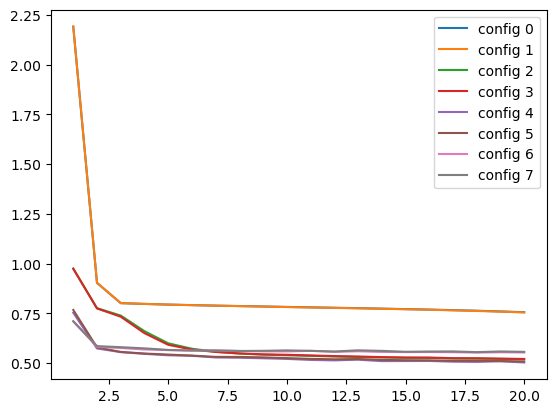

validation loss


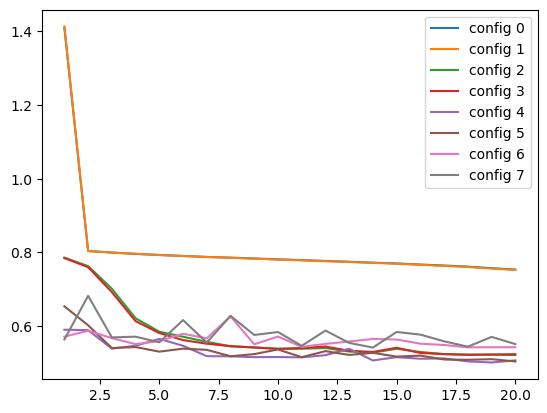

validation R2 score


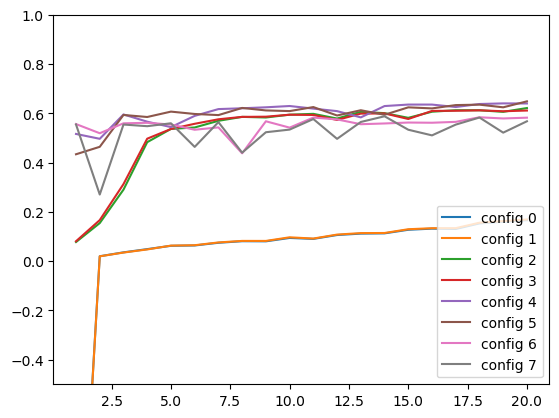

In [ ]:
with open("regression_results_crossval.npy", "rb") as f:
    training_stats = np.load(f)

NUM_EPOCHS = 20

# average across folds
average_trainloss = np.mean(training_stats[:, :, 0, :], axis=1)
average_valloss = np.mean(training_stats[:, :, 1, :], axis=1)
average_valr2 = np.mean(training_stats[:, :, 2, :], axis=1)

x_values = np.arange(NUM_EPOCHS) + 1
print("training loss")
for config_index in range(len(training_stats)):
    plt.plot(x_values, average_trainloss[config_index], label=f"config {config_index}")
plt.legend()
plt.show()
print("validation loss")
for config_index in range(len(training_stats)):
    plt.plot(x_values, average_valloss[config_index], label=f"config {config_index}")
plt.legend()
plt.show()
print("validation R2 score")
for config_index in range(len(training_stats)):
    plt.plot(x_values, average_valr2[config_index], label=f"config {config_index}")
plt.ylim(bottom=-0.5, top=1)  
plt.legend()
plt.show()

## Training the chosen model

In [ ]:
# config no.2
best_config = {'lr': 0.0001, 'layer_nodes': [48, 48, 32, 32], 'weight_decay': 1e-06}

train_data, val_data, test_data = prepare_data(classification=False)

x_train = train_data[:, :-1]
y_train = train_data[:, -1]

x_val = val_data[:, :-1]
y_val = val_data[:, -1]
            
x_train = torch.from_numpy(x_train).to("cpu", dtype=torch.float32)
y_train = torch.from_numpy(y_train).to("cpu", dtype=torch.float32)
x_val = torch.from_numpy(x_val).to("cpu", dtype=torch.float32)
y_val = torch.from_numpy(y_val).to("cpu", dtype=torch.float32)

torch.manual_seed(37)
best_model, results = neural_regressor.train_model(x_train, y_train, x_val, y_val, batch_size=BATCH_SIZE, num_epochs=100, patience=10, loss="MAE", **best_config)

Splitting with canton [3] as test set:
Total flows: 251,107
Train size: 231,064 rows (92.0%)
Test size: 20,043 rows (8.0%)
Test cantons: [3]
Splitting with canton [19] as test set:
Total flows: 231,064
Train size: 190,360 rows (82.4%)
Test size: 40,704 rows (17.6%)
Test cantons: [19]


Training 100 epochs::  43%|████▎     | 43/100 [03:06<04:06,  4.33s/it]

Out of patience. Ending training


In [ ]:
results = np.array(results)
with open("regression_results_model.npy", "wb") as f:
    np.save(f, results)

In [10]:
# save model parameters
save_path = pathlib.Path("./checkpoints/best_neural_regressor.pt")

In [11]:
torch.save(best_model, save_path)

## Evaluating the Model

In [ ]:
save_path = pathlib.Path("./checkpoints/best_neural_regressor.pt")
model = neural_regressor.FCNN([48,48,32,32])
model.load_state_dict(torch.load(save_path, weights_only=True))
model.eval()

FCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [13]:
_, val_data, test_data = prepare_data(classification=False)

Splitting with canton [3] as test set:
Total flows: 251,107
Train size: 231,064 rows (92.0%)
Test size: 20,043 rows (8.0%)
Test cantons: [3]
Splitting with canton [19] as test set:
Total flows: 231,064
Train size: 190,360 rows (82.4%)
Test size: 40,704 rows (17.6%)
Test cantons: [19]


In [14]:
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

x_test = torch.from_numpy(x_test).to("cpu", dtype=torch.float32)
y_test = torch.from_numpy(y_test).to("cpu", dtype=torch.float32)
test_set = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4096, shuffle=False)
predictions = np.array([])
with torch.no_grad():
    for x, y in test_loader:    
        log_preds = model(x).squeeze(1)
        predictions = np.append(predictions, np.exp(log_preds.numpy()))

test_r2 = r2_score(np.exp(y_test.numpy()), predictions)
test_mae = mean_absolute_error(np.exp(y_test.numpy()), predictions)
test_mse = mean_squared_error(np.exp(y_test.numpy()), predictions)

print("R2 score on test set:", test_r2)
print("MAE on test set:", test_mae)
print("MSE on test set:", test_mse)

R2 score on test set: 0.8426712436428538
MAE on test set: 15.72255482573962
MSE on test set: 2355.952043437686
